In [5]:
from fastai.data.all import *
from modules import FastSpeech
from data import TTSDataset, collate_fn
import librosa

In [6]:
torch.set_printoptions(precision=10, linewidth=140, sci_mode=False)

In [7]:
path_ds = Path("../data/LJSpeech-1.1/")
path_vocab = Path("../data/CMUDict/cmudict-0.7b.symbols.txt")
model_dir = Path("models/")
model_path = model_dir/"model_save_110.pt"

sample_rate = 22050
n_fft = 1024
hop_length = 256 
n_bins = 80
ratio = 0.01
preload = False
bs = 1

n_hidden = 384
n_heads = 2
kernal_sz = 3
n_filters = 1536
n_blocks = 6
upsample_ratio = 1

n_iter = 180

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
ds = TTSDataset(path_ds, path_vocab, sample_rate, n_fft, 
                hop_length, n_bins, ratio, preload)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True,
                                 collate_fn=partial(collate_fn, pad_num=ds.pad_num))

In [9]:
model = FastSpeech(len(ds.vocab), n_hidden, n_bins, n_heads, kernal_sz, 
                   n_filters, n_blocks, device).to(device)
n_params = sum(L(model.parameters()).map(lambda x: x.numel()))
print(f"Number of Parameters: {n_params}")

Number of Parameters: 49668944


In [10]:
model.load_state_dict(torch.load(model_path, map_location=device.type))
model = model.to(device)
model.train(mode=False)
dli = iter(dl)

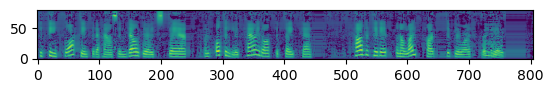

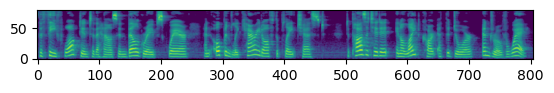

In [11]:
mels_val, phones_val, durations_val = map(lambda x: x.to(device), next(dli))
with torch.no_grad(): out = model(phones_val, durations_val, upsample_ratio)[0]
plt.imshow(librosa.power_to_db(out.numpy()), origin="lower");
plt.show()
plt.imshow(librosa.power_to_db(mels_val[0].numpy()), origin="lower");

In [12]:
torch.abs(out - mels_val).mean(), torch.square(out - mels_val).mean()

(tensor(0.0284754653), tensor(0.0753347054))

In [13]:
real_wav = librosa.feature.inverse.mel_to_audio(mels_val[0].numpy(), 
        sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_iter=n_iter)
pred_wav = librosa.feature.inverse.mel_to_audio(out.numpy(), 
        sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_iter=n_iter)

In [14]:
import IPython

IPython.display.display(IPython.display.Audio(pred_wav, rate=sample_rate))
IPython.display.display(IPython.display.Audio(real_wav, rate=sample_rate))